<a href="https://colab.research.google.com/github/AgunsBaba/Assignment/blob/master/Project_2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import modules
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Exploratory Data Analysis**

In [2]:
#import data
df = pd.read_excel('/content/Dry_Bean_Dataset.xlsx')
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [3]:
#check data shape and general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [4]:
#check for duplicates
df.duplicated().sum()

68

In [5]:
df.drop_duplicates(inplace=True) #drop duplicates
df.duplicated().sum() #check to see duplicates have been dropped

0

In [6]:
#check missing values
print(df.isna().sum().to_markdown())

|                 |   0 |
|:----------------|----:|
| Area            |   0 |
| Perimeter       |   0 |
| MajorAxisLength |   0 |
| MinorAxisLength |   0 |
| AspectRation    |   0 |
| Eccentricity    |   0 |
| ConvexArea      |   0 |
| EquivDiameter   |   0 |
| Extent          |   0 |
| Solidity        |   0 |
| roundness       |   0 |
| Compactness     |   0 |
| ShapeFactor1    |   0 |
| ShapeFactor2    |   0 |
| ShapeFactor3    |   0 |
| ShapeFactor4    |   0 |
| Class           |   0 |


There are no missing values

In [7]:
#check consistency of the labels in the target variable
df['Class'].value_counts(normalize=True)

DERMASON    0.261833
SIRA        0.194639
SEKER       0.149671
HOROZ       0.137340
CALI        0.120357
BARBUNYA    0.097615
BOMBAY      0.038544
Name: Class, dtype: float64

Labels for target variables are consistent

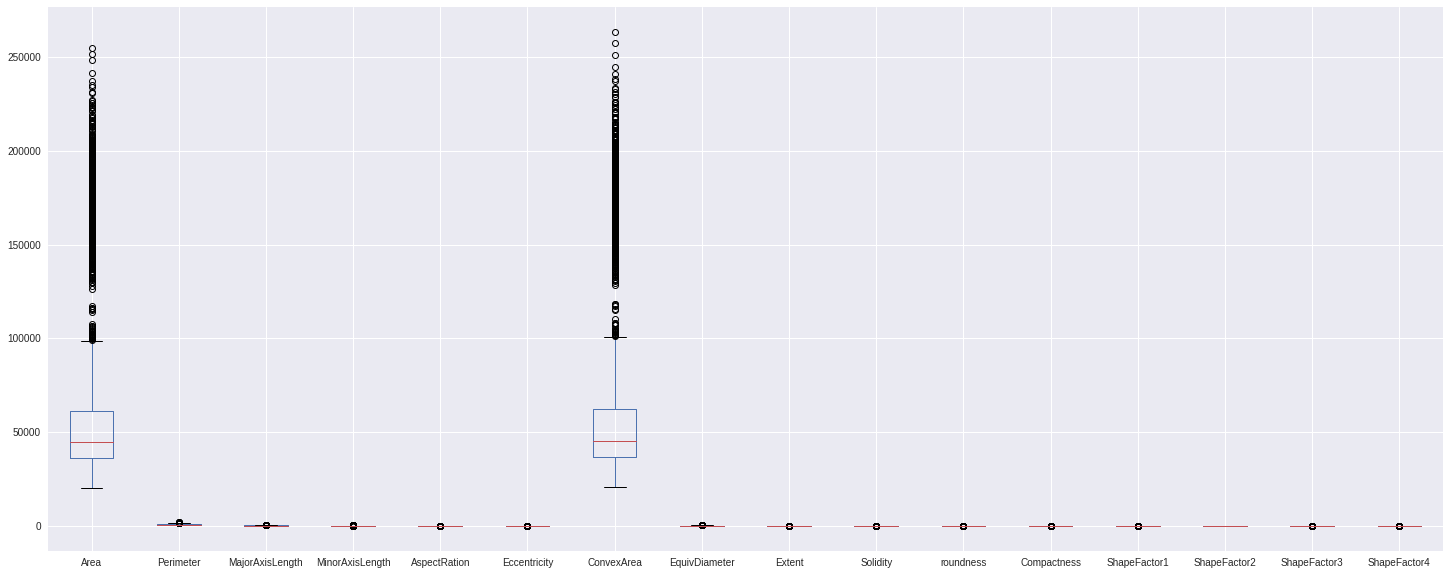

In [8]:
#check for outliers with boxplots
plt.style.use('seaborn')
df.boxplot(figsize=(25,10))
plt.show()

The Area and ConvexAarea variables are showing a lot of outliers. I'd first check the correlation between these two variables. 

In [9]:
corr = df['Area'].corr(df['ConvexArea'])
corr

0.9999396020129426

There's a strong correlation between the Area and ConvexArea variables. Since there's a strong correlation, I'll plot a bar chart of one of the variables (Area) and see if one of the target variables disproportionately have large values for Area. There's no need to plot bar chart for the two variables since they are highly correlated

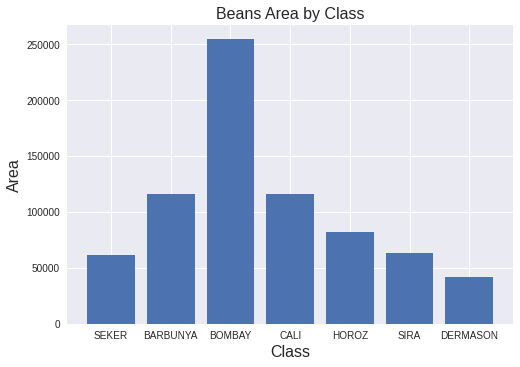

In [10]:
#plot bar chart
plt.bar(df['Class'], df['Area'])
plt.xlabel('Class', fontsize=16) #create x-axis labels
plt.ylabel('Area', fontsize=16) #create y-axis labels
plt.title('Beans Area by Class', fontsize=16); #create a title for the chart


From the plot above, the 'Bombay' class of Beans seems to have a disproportionately large Area, so the outliers observed is not abnormal

In [11]:
!pip install dython

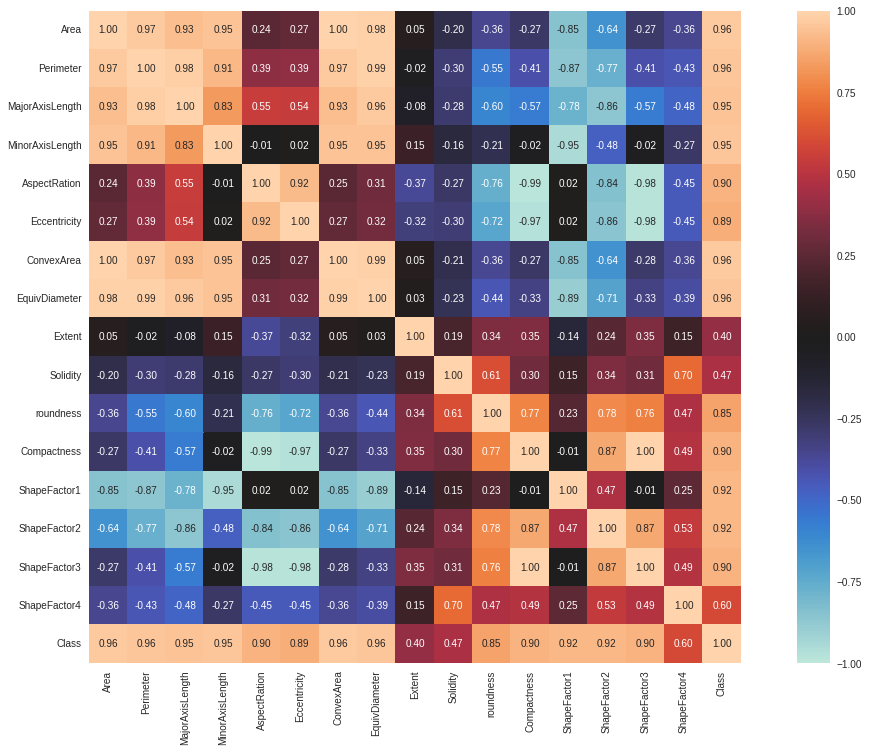

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5ceea6e5d0>,
 'corr':                      Area  Perimeter  ...  ShapeFactor4     Class
 Area             1.000000   0.966908  ...     -0.358019  0.963253
 Perimeter        0.966908   1.000000  ...     -0.431215  0.956626
 MajorAxisLength  0.932623   0.977561  ...     -0.484464  0.951608
 MinorAxisLength  0.952041   0.914336  ...     -0.266402  0.953215
 AspectRation     0.243698   0.386097  ...     -0.451598  0.904907
 Eccentricity     0.268580   0.391062  ...     -0.450611  0.885102
 ConvexArea       0.999940   0.967871  ...     -0.364302  0.963188
 EquivDiameter    0.984998   0.991453  ...     -0.394693  0.958481
 Extent           0.054648  -0.020620  ...      0.148622  0.399036
 Solidity        -0.197333  -0.304662  ...      0.700150  0.468205
 roundness       -0.359068  -0.548336  ...      0.472776  0.853836
 Compactness     -0.269797  -0.407426  ...      0.486334  0.903212
 ShapeFactor1    -0.848390  -0.865756  ...      0.25116

In [12]:
#correlation heatmap using dython
from dython.nominal import associations
associations(df, figsize=(20,12))


From the plot, Extent and Solidity has the least correlation with Class (the target variable), while the other variables have strong correlation (>=0.85) with Class 

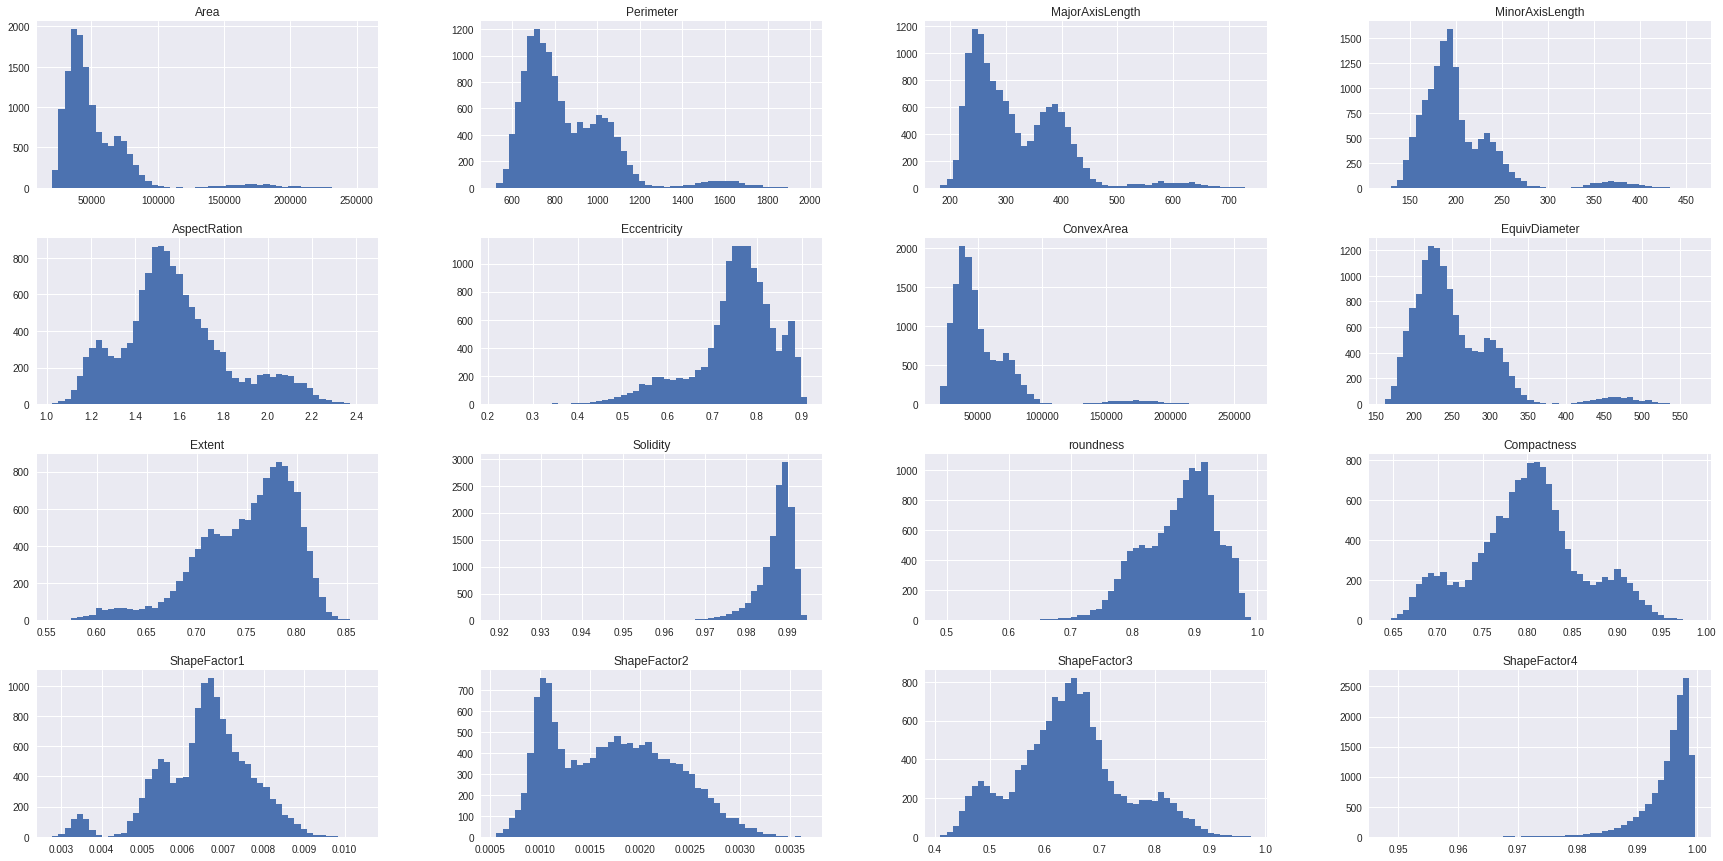

In [13]:
#plot histogram to get a feel of the shape/distribution of the variables
df.hist(bins=50, figsize=(30,15))
plt.show()

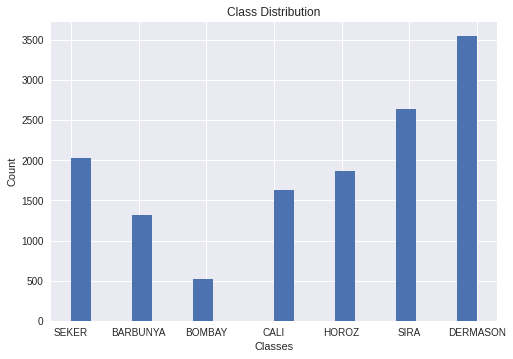

In [14]:
#plot a histogram to see the distribution of the target labels in the dataframe
df['Class'].hist(bins=20)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

**Data Preprocessing**

In [15]:
#Split data into features and target
X = df.drop(columns='Class')
y = df['Class']

In [16]:
#split data into training and testing sets
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

There's no major preprocessing step as all the features in the dataset are all numerical (i.e. there are no categorical or ordinal features). So the only thing I'll do is to standardize the dataset.

In [17]:
#Data preprocessing

#select numerical column
num = make_column_selector(dtype_exclude=object)

#Instantiate Standard Scaler
scaler = StandardScaler()

#make pipeline for numerical data
num_pipe = make_pipeline(scaler)

#make tuple for numerical data
num_tuple = (num_pipe, num)

#Transform numerical columns
num_col = make_column_transformer(num_tuple, remainder='passthrough')

For this project, I am going to try the LGBM and XGB models

---

**Initial Model Instantiation, Fitting and Classification Report Generation for the LGBM Model**


In [18]:
#instantiate the LGBM model
lgbm = LGBMClassifier(random_state=42)

#create model pipeline
lgbm_pipe = make_pipeline(num_col, lgbm)

In [19]:
#fit the model
lgbm_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cee9c6d10>)])),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

In [20]:
#generate lgbm classification report
pred_lgbm = lgbm_pipe.predict(X_test)
pred_lgbm_train = lgbm_pipe.predict(X_train)

print(classification_report(y_test, pred_lgbm))
print(classification_report(y_train, pred_lgbm_train))

              precision    recall  f1-score   support

    BARBUNYA       0.94      0.93      0.94       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.96      0.94      0.95       326
    DERMASON       0.90      0.92      0.91       709
       HOROZ       0.97      0.95      0.96       372
       SEKER       0.95      0.95      0.95       406
        SIRA       0.86      0.86      0.86       527

    accuracy                           0.92      2709
   macro avg       0.94      0.94      0.94      2709
weighted avg       0.92      0.92      0.92      2709

              precision    recall  f1-score   support

    BARBUNYA       1.00      1.00      1.00      1057
      BOMBAY       1.00      1.00      1.00       418
        CALI       1.00      1.00      1.00      1304
    DERMASON       0.99      0.99      0.99      2837
       HOROZ       1.00      1.00      1.00      1488
       SEKER       1.00      1.00      1.00      1621
        SIRA       0.99 

Bssed on the report above, there seems to be some overfitting of the training data going on, especially for the SIRA class. I'll tune the hyperparameters to see if we can get the model to perform better and reduce the overfitting.

In [21]:
#get the list of parameters that can be tuned
lgbm_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cee9c6d10>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline': Pipeline(steps=[('standardscaler', StandardScaler())]),
 'columntransformer__pipeline__memory': None,
 'columntransformer__pipeline__standardscaler': StandardScaler(),
 'columntransformer__pipeline__standardscaler__copy': True,
 'columntransformer__pipeline__standardscaler__with_mean': True,
 'columntransformer__pipeline__standardscaler__with_std': True,
 'columntransformer__pipeline__steps': [('standardscaler', StandardScaler())],
 'columntransformer__pipeline__verbose': False,
 'columntransformer__remainder': 'passthrough',
 'columntransformer__spars

In [22]:
#create a hyperparameter dictionary
lgbm_param = {'lgbmclassifier__max_depth': [1, 10, 20 ],
              'lgbmclassifier__n_estimators': [100, 200, 300]}

grid_lgbm = GridSearchCV(lgbm_pipe, lgbm_param) #instantiate GridSearch

#fit the GridSearch
grid_lgbm.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cee9c6d10>)])),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'lgbmclassifier__max_depth': [1, 10, 20],
                         'lgbmclassifier__n_estimators': [100, 200, 300]})

In [23]:
#get the best estimators from Grid search
lgbm_best = grid_lgbm.best_estimator_
lgbm_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cf19726d0>)])),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=20, random_state=42))])

In [24]:
#fit tuned lgbm model
lgbm_best.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cf19726d0>)])),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=20, random_state=42))])

In [25]:
#generate classification report for the tuned lgbm model

lgbm_best_pred = lgbm_best.predict(X_train) #y_pred for training data
lgbm_best_test = lgbm_best.predict(X_test) #y_pred for testing data

#print classification report
print(classification_report(y_test, lgbm_best_test ))
print(classification_report(y_train, lgbm_best_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.94      0.93      0.94       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.96      0.94      0.95       326
    DERMASON       0.91      0.92      0.91       709
       HOROZ       0.97      0.95      0.96       372
       SEKER       0.95      0.95      0.95       406
        SIRA       0.86      0.86      0.86       527

    accuracy                           0.92      2709
   macro avg       0.94      0.94      0.94      2709
weighted avg       0.92      0.92      0.92      2709

              precision    recall  f1-score   support

    BARBUNYA       1.00      1.00      1.00      1057
      BOMBAY       1.00      1.00      1.00       418
        CALI       1.00      1.00      1.00      1304
    DERMASON       0.99      0.99      0.99      2837
       HOROZ       1.00      1.00      1.00      1488
       SEKER       1.00      1.00      1.00      1621
        SIRA       0.99 

Metrics from the tuned model looks slightly better than the vanilla, untuned lgbm model. The tuned model is also not overfitting the training data for the SIRA class as much as the untuned model. One way I feel this performance can be improved is to experiment with Stratified Random Sampling in splitting the data and see whether the model will even overfit less on the training data

**Initial Model Instantiation, Fitting and Classification Report Generation for the XGB Model**

In [26]:
#instantiate the xgb model
xgb = XGBClassifier(randome_state=42)

#create model pipeline
xgb_pipe = make_pipeline(num_col, xgb)

#fit the xgb model
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cee9c6d10>)])),
                ('xgbclassifier',
                 XGBClassifier(objective='multi:softprob', randome_state=42))])

In [27]:
#generate xgb classification report
pred_xgb = xgb_pipe.predict(X_test)
pred_xgb_train = xgb_pipe.predict(X_train)

print(classification_report(y_test, pred_xgb))
print(classification_report(y_train, pred_xgb_train))

              precision    recall  f1-score   support

    BARBUNYA       0.94      0.90      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.94      0.95      0.94       326
    DERMASON       0.91      0.92      0.91       709
       HOROZ       0.96      0.96      0.96       372
       SEKER       0.95      0.95      0.95       406
        SIRA       0.86      0.86      0.86       527

    accuracy                           0.92      2709
   macro avg       0.94      0.93      0.94      2709
weighted avg       0.92      0.92      0.92      2709

              precision    recall  f1-score   support

    BARBUNYA       0.97      0.95      0.96      1057
      BOMBAY       1.00      1.00      1.00       418
        CALI       0.96      0.97      0.96      1304
    DERMASON       0.92      0.94      0.93      2837
       HOROZ       0.97      0.96      0.97      1488
       SEKER       0.97      0.97      0.97      1621
        SIRA       0.90 

I really like the performance of this model. Unlike the lgbm model, this model is overfitting much less on the training data for the SIRA class (as well as overall). I'd tune some hyperparameters to see if we can even get the model to perform better.

In [28]:
#get hyperparameters that can be tuned
xgb_pipe.get_params()

{'columntransformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('pipeline',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cee9c6d10>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline': Pipeline(steps=[('standardscaler', StandardScaler())]),
 'columntransformer__pipeline__memory': None,
 'columntransformer__pipeline__standardscaler': StandardScaler(),
 'columntransformer__pipeline__standardscaler__copy': True,
 'columntransformer__pipeline__standardscaler__with_mean': True,
 'columntransformer__pipeline__standardscaler__with_std': True,
 'columntransformer__pipeline__steps': [('standardscaler', StandardScaler())],
 'columntransformer__pipeline__verbose': False,
 'columntransformer__remainder': 'passthrough',
 'columntransformer__spars

In [29]:
#create hyperparameter dictionary
xgb_params = {'xgbclassifier__max_depth': [3, 5, 10],
              'xgbclassifier__n_estimators': [100, 200, 300]}

#Instantiate GridSearch
xgb_grid = GridSearchCV(xgb_pipe, xgb_params)

#fit GridSearch
xgb_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cee9c6d10>)])),
                                       ('xgbclassifier',
                                        XGBClassifier(objective='multi:softprob',
                                                      randome_state=42))]),
             param_grid={'xgbclassifier__max_depth': [3, 5, 10],
                         'xgbclassifier__n_estimators': [100, 200, 300]})

In [30]:
#get the best estimator for the xgb model
xgb_best = xgb_grid.best_estimator_
xgb_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cf565b110>)])),
                ('xgbclassifier',
                 XGBClassifier(max_depth=5, n_estimators=300,
                               objective='multi:softprob', randome_state=42))])

In [31]:
#fit tuned xgb model
xgb_best.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5cf565b110>)])),
                ('xgbclassifier',
                 XGBClassifier(max_depth=5, n_estimators=300,
                               objective='multi:softprob', randome_state=42))])

In [32]:
#generate classification report for tuned and untuned xgb models
xgb_best_train = xgb_best.predict(X_train)
xgb_best_test = xgb_best.predict(X_test)

print('>>>>>This is for the tuned xgb model<<<<<<')
print(classification_report(y_test, xgb_best_test))
print(classification_report(y_train, xgb_best_train))

print('>>>>>>This is for the untuned xgb model<<<<<<')
print(classification_report(y_test, pred_xgb))
print(classification_report(y_train, pred_xgb_train))

>>>>>This is for the tuned xgb model<<<<<<
              precision    recall  f1-score   support

    BARBUNYA       0.93      0.92      0.93       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.95      0.94      0.95       326
    DERMASON       0.91      0.92      0.91       709
       HOROZ       0.97      0.95      0.96       372
       SEKER       0.95      0.95      0.95       406
        SIRA       0.86      0.87      0.86       527

    accuracy                           0.92      2709
   macro avg       0.94      0.93      0.94      2709
weighted avg       0.92      0.92      0.92      2709

              precision    recall  f1-score   support

    BARBUNYA       1.00      1.00      1.00      1057
      BOMBAY       1.00      1.00      1.00       418
        CALI       1.00      1.00      1.00      1304
    DERMASON       0.99      1.00      1.00      2837
       HOROZ       1.00      1.00      1.00      1488
       SEKER       1.00      1.00  

From the result above, the tuned xgb model is better than the untuned xgb model since it has better overall accuracy.

**Model Recommendation**

The tuned xgb model has an overall better accuracy than the the tuned lgbm model. Furthermore, the tuned xgb model does not overfit the training data as much as the tuned lgbm model. The performance on the 'SIRA' class of beans is however a source of concern. The recommendation at this point would be to obtain more data to train the model in order to improve the accuracy for the ‘SIRA’ class of beans before deploying to production


Link to Final presentation: [link text](https://docs.google.com/presentation/d/1yGF73Ral9IP0eTbic46YP1DehbsPhtnv/edit?usp=sharing&ouid=113073467099480959479&rtpof=true&sd=true)